In [1]:
library(tidyverse)
library(networkD3)
library(htmlwidgets)
library(webshot)
library(RColorBrewer)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘htmlwidgets’

The following object is masked from ‘package:networkD3’:

    JS



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
dsets <- c("unified_cervical_data")
dset_paths <- unlist(map(dsets, function(d) paste0(dirs$data_dir, "/", d)))
matrisome_list <- matrisome_list <- paste(dirs$data_dir, "matrisome", "matrisome_hs_masterlist.tsv", sep = "/")
dset_idx <- 1

Warning message in readLines(con):
“incomplete final line found on '../dev_paths.txt'”

# Functions

In [3]:
to_vplot_df <- function(df) {
    vplot_df <- df %>%
        dplyr::rename(log2_fc = log2FoldChange) %>%
        dplyr::rename(gene_ID = geneID) %>%
        dplyr::rename(base_mean = baseMean) %>%
        dplyr::mutate(neg_log10_padj = -log10(padj)) %>%
        dplyr::select(gene_ID, base_mean, log2_fc, neg_log10_padj, padj, pvalue)
    return(vplot_df)
}


make_vplot <- function(df, add_contour = FALSE, jitter_w = 0, jitter_h = 0, abs_log2_fc_outlier_thresh = 15, padj_thresh = 1e-10) {
    lfc_outliers_df <- df %>%
        dplyr::filter(abs(log2_fc) > abs_log2_fc_outlier_thresh) %>%
        dplyr::filter(padj < padj_thresh)
    
    plt <- ggplot() +
        geom_point(data = df, aes(y = neg_log10_padj, x = log2_fc), size = 0.25, position = position_jitter(w = jitter_w, h = jitter_h)) +
        {if (add_contour) geom_density2d(aes(colour=..level..))} +
        {if (add_contour) scale_colour_gradient(low = "#00e600", high="#cc0000", name = "Density")} +
        geom_hline(yintercept = -log10(0.05), linetype = "longdash", colour = "#737373", size = 0.5) +
        geom_vline(xintercept = log2(2), linetype = "longdash", colour = "#BE684D", size = 0.5) +
        geom_vline(xintercept = -1, linetype = "longdash", colour = "#2C467A", size = 0.5) +
        {if (nrow(lfc_outliers_df) > 0) geom_label_repel(data = lfc_outliers_df, aes(label = gene_ID, y = neg_log10_padj, x = log2_fc), size = 2)} +
        labs(title = "Matrisome DEG Analysis",
            subtitle = "CESC") +
        xlab("log2 fold-change") +
        ylab("-log10(adj. p-val)") +
        guides(alpha="none")

    return(plt)
}

# Load data

In [4]:
matrisome_summary_df <- read_tsv(paste0(dirs$analysis_dir, "/", dsets[dset_idx], "_matrisome_summary.tsv"))
dge_res_df <- read_tsv(paste0(dirs$analysis_dir, "/", dsets[dset_idx], "_DESeq_results.tsv"))

Parsed with column specification:
cols(
  geneID = col_character(),
  in_unified_dataset = col_logical(),
  lowly_expressed = col_logical(),
  division = col_character(),
  category = col_character(),
  gene_name = col_character(),
  synonyms = col_character(),
  hgnc_ids = col_double(),
  hgnc_ids_links = col_double(),
  uniprot_ids = col_character(),
  refseq_ids = col_character(),
  orthology = col_character(),
  notes = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double()
)
Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double()
)


# Volcano plots

Saving 6.67 x 6.67 in image


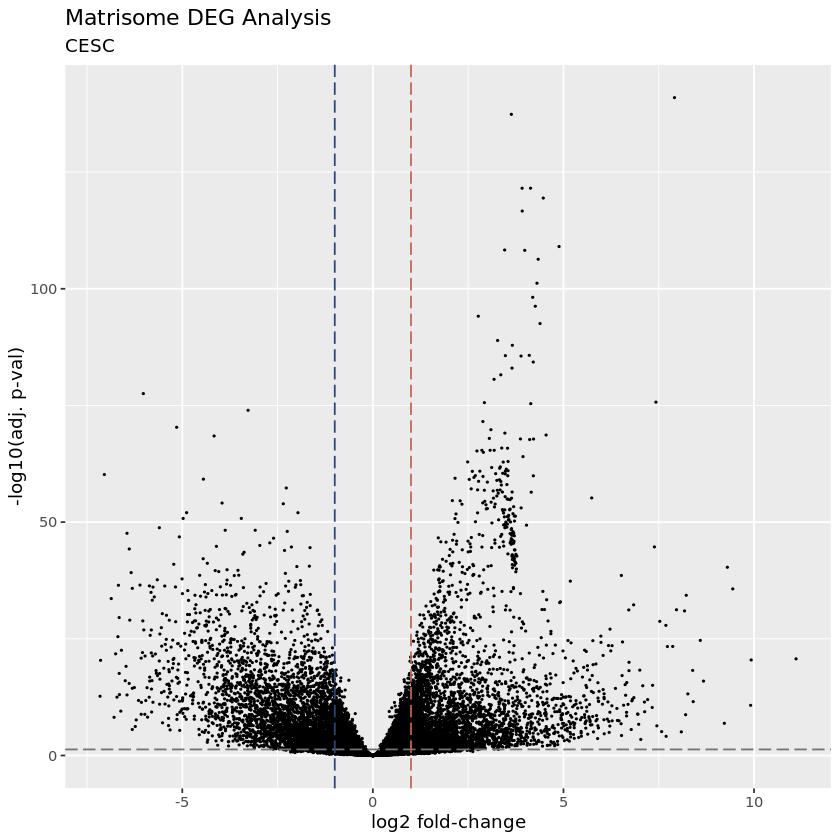

In [5]:
dge_res_df %>%
    to_vplot_df() %>%
    make_vplot()
ggsave(paste0(dirs$figures_dir, "/all_genes_vplot.png"), last_plot())

Warning message:
“Removed 110 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 110 rows containing missing values (geom_point).”

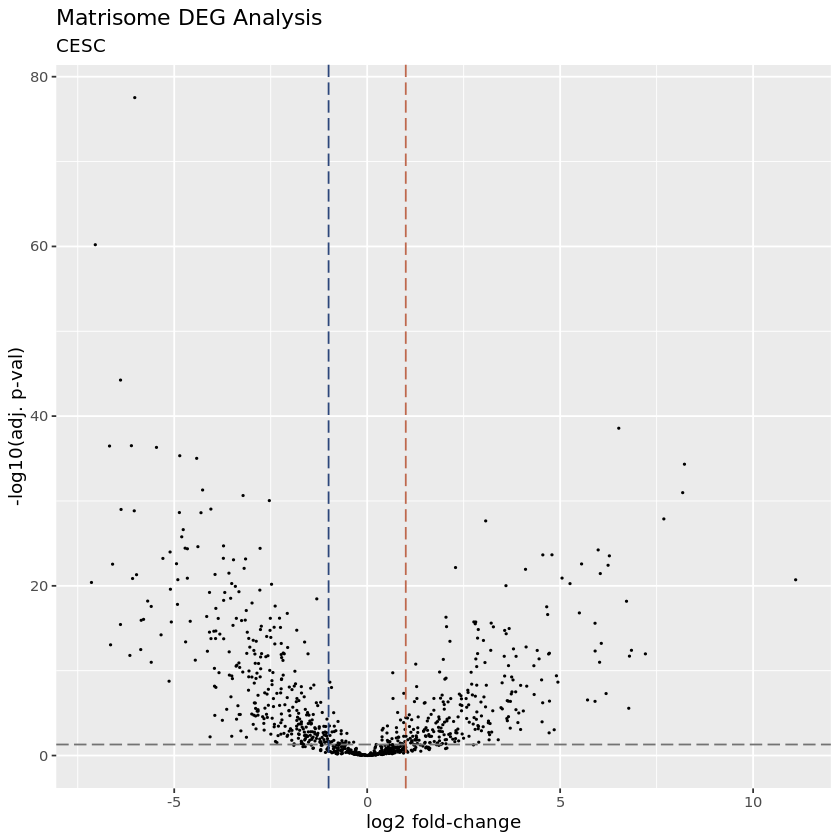

In [6]:
matrisome_summary_df %>%
    to_vplot_df() %>%
    make_vplot()
ggsave(paste0(dirs$figures_dir, "/matrisome_genes_vplot.png"), last_plot())

# Sankey diagram

In [7]:
sd_df <- matrisome_summary_df %>%
    mutate(gene_list = rep("Matrisome genes", nrow(matrisome_summary_df))) %>%
    mutate(in_dset = ifelse(in_unified_dataset, "In dataset", "Not in dataset")) %>%
    mutate(expr_type = ifelse(lowly_expressed, "Lowly expressed", "Sufficiently expressed")) %>%
    mutate(DEG_cat = ifelse((padj < 0.05 & abs(log2FoldChange) > log2(2)) , "Sig. DEGs", "Non-sig. DEGs")) %>%
    dplyr::select(gene_list, in_dset, expr_type, DEG_cat, category)
head(sd_df)

gene_list,in_dset,expr_type,DEG_cat,category
<chr>,<chr>,<chr>,<chr>,<chr>
Matrisome genes,In dataset,Sufficiently expressed,Sig. DEGs,ECM Glycoproteins
Matrisome genes,In dataset,Lowly expressed,NA,ECM Glycoproteins
Matrisome genes,In dataset,Sufficiently expressed,Sig. DEGs,ECM Glycoproteins
Matrisome genes,In dataset,Sufficiently expressed,Sig. DEGs,ECM Glycoproteins
Matrisome genes,In dataset,Lowly expressed,NA,ECM Glycoproteins
Matrisome genes,In dataset,Lowly expressed,NA,ECM Glycoproteins


In [8]:
source_v = c()
target_v = c()
value_v = c()

In [9]:
# Matrisome list -> in or out of dataset?
sd1_df <- sd_df %>%
    group_by(gene_list, in_dset) %>%
    summarize(n = n()) %>%
    mutate(gene_list_with_n = paste0(gene_list, ": ", sum(n[gene_list == "Matrisome genes"]))) %>%
    mutate(in_dset_with_n = paste0(in_dset, ": ", n))
# sd1_df

source_v <- c(source_v, sd1_df$gene_list_with_n)
target_v <- c(target_v, sd1_df$in_dset_with_n)
value_v <- c(value_v, sd1_df$n)

# In dataset -> lowly expr. or sufficiently expr.?
sd2_df <- sd_df %>%
    group_by(in_dset, expr_type) %>%
    dplyr::filter(in_dset == "In dataset") %>%
    summarize(n = n()) %>%
    mutate(in_dset_with_n = paste0(in_dset, ": ", sum(n[in_dset == "In dataset"]))) %>%
    mutate(expr_type_with_n = paste0(expr_type, ": ", n))
# sd2_df

source_v <- c(source_v, sd2_df$in_dset_with_n)
target_v <- c(target_v, sd2_df$expr_type_with_n)
value_v <- c(value_v, sd2_df$n)

sd3_df <- sd_df %>%
    group_by(expr_type, DEG_cat) %>%
    dplyr::filter(expr_type == "Sufficiently expressed") %>%
    summarize(n = n()) %>%
    mutate(expr_type_with_n = paste0(expr_type, ": ", sum(n[expr_type == "Sufficiently expressed"]))) %>%
    mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", n))
# sd3_df

source_v <- c(source_v, sd3_df$expr_type_with_n)
target_v <- c(target_v, sd3_df$DEG_cat_with_n)
value_v <- c(value_v, sd3_df$n)

sd4_df <- sd_df %>%
    mutate(category = replace(category, category == "ECM Glycoproteins", "Glycoproteins (ECM)")) %>%
    mutate(category = replace(category, category == "ECM Regulators", "Regulators (ECM)")) %>%
    group_by(DEG_cat, category) %>%
    dplyr::filter(DEG_cat == "Sig. DEGs") %>%
    summarize(n = n()) %>%
    mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", sum(n[DEG_cat == "Sig. DEGs"]))) %>%
    mutate(category_with_n = paste0(category, ": ", n))
sd4_df

source_v <- c(source_v, sd4_df$DEG_cat_with_n)
target_v <- c(target_v, sd4_df$category_with_n)
value_v <- c(value_v, sd4_df$n)

`summarise()` regrouping output by 'gene_list' (override with `.groups` argument)
`summarise()` regrouping output by 'in_dset' (override with `.groups` argument)
`summarise()` regrouping output by 'expr_type' (override with `.groups` argument)
`summarise()` regrouping output by 'DEG_cat' (override with `.groups` argument)


DEG_cat,category,n,DEG_cat_with_n,category_with_n
<chr>,<chr>,<int>,<chr>,<chr>
Sig. DEGs,Collagens,28,Sig. DEGs: 559,Collagens: 28
Sig. DEGs,ECM-affiliated Proteins,90,Sig. DEGs: 559,ECM-affiliated Proteins: 90
Sig. DEGs,Glycoproteins (ECM),113,Sig. DEGs: 559,Glycoproteins (ECM): 113
Sig. DEGs,Proteoglycans,24,Sig. DEGs: 559,Proteoglycans: 24
Sig. DEGs,Regulators (ECM),123,Sig. DEGs: 559,Regulators (ECM): 123
Sig. DEGs,Secreted Factors,181,Sig. DEGs: 559,Secreted Factors: 181


In [10]:
links_df <- tibble(
    source = source_v,
    target = target_v,
    value = value_v,
)

nodes_df <- tibble(
    name = c(links_df$source, links_df$target) %>% unique()
)

links_df$sourceID <- match(links_df$source, nodes_df$name) - 1
links_df$targetID <- match(links_df$target, nodes_df$name) - 1

In [11]:
sn <- sankeyNetwork(
    Links = links_df,
    Nodes = nodes_df,
    Source = "sourceID",
    Target = "targetID",
    Value = "value",
    NodeID = "name",
    fontSize = 24,
    fontFamily = "calibri",
    sinksRight=FALSE
)

Links is a tbl_df. Converting to a plain data frame.
Nodes is a tbl_df. Converting to a plain data frame.


In [12]:
sn
saveNetwork(sn, paste0(dirs$figures_dir, "/matrisome_sankey_diagram.html"))

HTML widgets cannot be represented in plain text (need html)